## Download data  

In [1]:
# !gdown --id 1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

## Load Data

In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/Data/Auto_MPG_data.csv")
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Tiền xử lý dữ liệu dạng table

### Lấy label và chia bộ dữ liệu train/val

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
val_dataset = dataset.drop(train_dataset.index)

In [6]:
X_train = train_dataset.copy()
X_val = val_dataset.copy()

y_train = X_train.pop('MPG')
y_val = X_val.pop('MPG')

X_train, y_train = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)

### Chuẩn hóa dữ liệu (Data Standardisation)

In [7]:
_MEAN = X_train.mean(axis=0)
_STD = X_train.std(axis=0)

X_train = ( X_train-_MEAN)/_STD
X_val = ( X_val-_MEAN)/_STD

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # print(idx)
        return self.X[idx], self.y[idx]

In [9]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Sử dụng Tensorflow để  build, compile và train và evaluate model. Kết quả train và evaluation được thể hiện bằng hình ảnh bằng cách sử dụng matplotlib

### MLP for Regressuion - MSE

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

model = MLP(input_dims=9, hidden_dims=64, output_dims=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [11]:
def r_squared(y_true, y_pred):
    """
    Compute R^2 score.
    """
    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [12]:
num_epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        train_predict.extend(outputs.tolist())
        train_target.extend(y.tolist())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            val_predict.extend(outputs.tolist())
            val_target.extend(y.tolist())
            loss = criterion(outputs, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Validation Loss: {val_loss:.4f}")

Epoch 1/100, Train_Loss: 349.4243,  Validation Loss: 27.1808
Epoch 2/100, Train_Loss: 20.4971,  Validation Loss: 11.3844
Epoch 3/100, Train_Loss: 17.7197,  Validation Loss: 9.4902
Epoch 4/100, Train_Loss: 11.4268,  Validation Loss: 9.2070
Epoch 5/100, Train_Loss: 9.7830,  Validation Loss: 8.9023
Epoch 6/100, Train_Loss: 8.9946,  Validation Loss: 7.5636
Epoch 7/100, Train_Loss: 10.5826,  Validation Loss: 17.1286
Epoch 8/100, Train_Loss: 8.2227,  Validation Loss: 8.6566
Epoch 9/100, Train_Loss: 8.3551,  Validation Loss: 7.6623
Epoch 10/100, Train_Loss: 7.9830,  Validation Loss: 10.7803
Epoch 11/100, Train_Loss: 8.2312,  Validation Loss: 7.1423
Epoch 12/100, Train_Loss: 7.5095,  Validation Loss: 6.6594
Epoch 13/100, Train_Loss: 8.2816,  Validation Loss: 13.2485
Epoch 14/100, Train_Loss: 8.3010,  Validation Loss: 6.7308
Epoch 15/100, Train_Loss: 7.6029,  Validation Loss: 7.9081
Epoch 16/100, Train_Loss: 7.2687,  Validation Loss: 8.6493
Epoch 17/100, Train_Loss: 7.6837,  Validation Loss: 7.

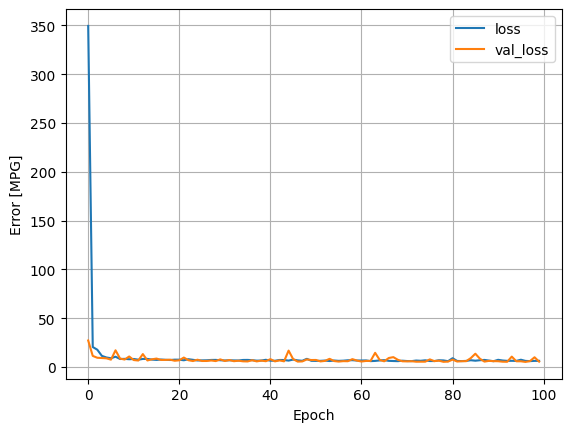

In [13]:
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

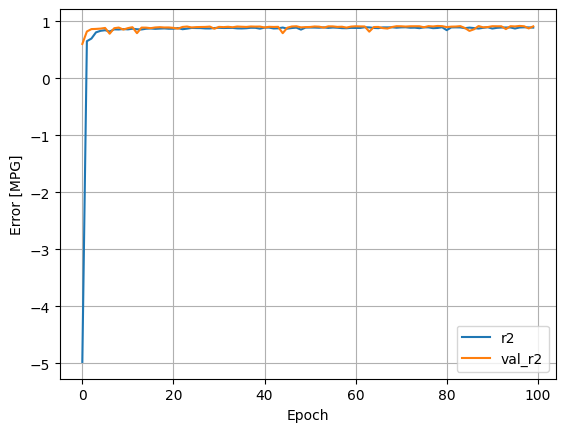

In [14]:
plt.plot(train_r2, label='r2')
plt.plot(val_r2, label='val_r2')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)